In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P

def plotSinusoid(k, d=512, n=10000):
    x = np.arange(0, 100, 1)
    denominator = np.power(n, 2*x/d)
    y = np.sin(k/denominator)
    plt.plot(x, y)
    plt.title('k = ' + str(k))

P = getPositionEncoding(seq_len=100, d=128, n=10000)
fig, ax = plt.subplots()
cax = ax.matshow(P)
plt.gcf().colorbar(cax)
ax.set_xlabel("Embedding Dimension")
ax.set_ylabel("Time")

fig.savefig("EmbeddingMatrix.pdf",dpi=300)

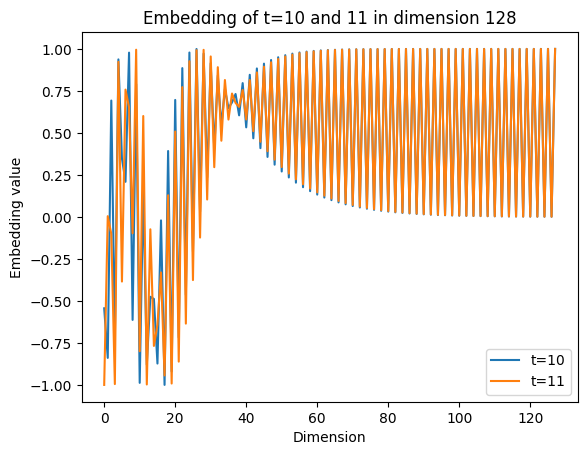

In [36]:
fig,ax=plt.subplots()

ax.plot(P[10],label="t=10")
ax.set_ylabel("Embedding value")
ax.set_xlabel("Dimension")
ax.set_title("Embedding of t=10 in dimension 128")

ax.plot(P[11],label="t=11")
ax.set_ylabel("Embedding value")
ax.set_xlabel("Dimension")
ax.set_title("Embedding of t=10 and 11 in dimension 128")
ax.legend()
fig.savefig("PE_t10_et_11.pdf",dpi=300)

In [2]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, in_dim, out_dim, key_dim):
        super().__init__()
        self.conv_Q = nn.Conv1d(in_dim, key_dim, kernel_size = 1, bias = False)
        self.conv_K = nn.Conv1d(in_dim, key_dim, kernel_size = 1, bias = False)
        self.conv_V = nn.Conv1d(in_dim, out_dim, kernel_size = 1, bias = False)
        
    def forward(self, x):
        #print(x.shape)
        Q = self.conv_Q(x)
        K = self.conv_K(x)
        V = self.conv_V(x)
        #print("Q",Q.shape,"K", K.shape, "V",V.shape)
        A = torch.einsum('nct,ncs->nts', Q, K).softmax(2)
        y = torch.einsum('nts,ncs->nct', A, V)
        
        return y, A.detach()

class SelfAttentionCNN(nn.Module):
    def __init__(self, in_dim, out_dim, key_dim):
        super().__init__()
        self.in_net = nn.Sequential(*[
                    nn.Conv1d(in_dim, key_dim, kernel_size=(5,), stride=(1,), padding=(2,)),
                    nn.ReLU(), 
                    nn.Conv1d(key_dim, key_dim, kernel_size=(5,), stride=(1,), padding=(2,)), 
                    nn.ReLU()
                    ])
        
        self.attn_net = SelfAttentionLayer(in_dim=key_dim, out_dim=key_dim, key_dim=key_dim)
    
        self.out_net=nn.Sequential(*[
                        nn.Conv1d(key_dim, key_dim, kernel_size=(5,), stride=(1,), padding=(2,)),
                        nn.ReLU(),
                        nn.Conv1d(key_dim, out_dim, kernel_size=(5,), stride=(1,), padding=(2,))
                    ])
    
    def forward(self, x, explain=False):
        y = self.in_net(x)
        y, A = self.attn_net(y)
        y = self.out_net(y)
        if explain:
            return y,A
        else:
            return y
        
        
def interp(x_np):
    xx = np.arange(x_np.shape[0])
    x_notnan_b = ~np.isnan(x_np).bool().numpy()
    return torch.from_numpy(np.interp(xx, xx[x_notnan_b], x_np[x_notnan_b]))

def find_target(l_d):
    lout=[{k:v for k,v in dd.items()} for dd in l_d]
    avg_d= {k:np.mean([dd["val"] for dd in l_d if dd["type"] ==k])
            for k in ["tri","rect"]}
    for dd in lout:
        dd["val"]=avg_d[dd["type"]]
    return lout

def apply_shape(xx, shp):
    xx[shp["start"]: shp["end"]]=torch.nan
    
    if shp["type"] == "tri":
        xx[shp["start"] + (shp["end"]-shp["start"])//2]=shp["val"]
    elif shp["type"] == "rect":
        xx[shp["start"]:shp["end"]]=shp["val"]
    
    return xx

def add_noise(x,s=0.1):
    return x+torch.randn_like(x)*s

In [3]:
def draw_pattern(T=100):
    
    min_w = 10
    max_w = 15
    n=4
    the_diffs = torch.randint(max_w+1, T//n, (n,)).sort().values
    the_diffs[0]-=max_w
    the_starts = torch.cumsum(the_diffs,0)
    
    the_ends = the_starts + torch.randint(3,max_w,the_starts.shape)
    the_ends[-1]=min([the_ends[-1],T-1])
    
    the_val= torch.randint(10,20,(n,)).cumsum(0)
    indexes = torch.randperm(the_val.shape[0])
    the_val = the_val[indexes]
    
    names=["tri","rect", "tri","rect"]
    random.shuffle(names)
    return [{"start":start.item(),"end":end.item(),"val":val.item(),"type":name} for (start,end,val,name) in zip(the_starts,the_ends,the_val,names)]


In [4]:
def gen_data(N,T,s=0):
    X=torch.zeros(N,1,T)
    Y=torch.zeros(N,1,T)

    ltrain = [draw_pattern(T=T) for _ in range(N)]

    for i, ll in enumerate(ltrain):
        for shp,shp_target in zip(ll,find_target(ll)):
            X[i,0,:] = add_noise(interp(apply_shape(X[i,0,:], shp)),s=s_noise).float()
            Y[i,0,:] = add_noise(interp(apply_shape(Y[i,0,:], shp_target)),s=s_noise).float()
    return X,Y


In [5]:
model1=lambda :nn.Sequential(*[nn.Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,)),nn.ReLU(),
nn.Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,)),nn.ReLU(),
nn.Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,)),nn.ReLU(),
nn.Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,)),nn.ReLU(),
nn.Conv1d(64, 1, kernel_size=(5,), stride=(1,), padding=(2,))]
)

model2=lambda :SelfAttentionCNN(1,1,64)

In [6]:
T = 100
s_noise = 0.1
N = 25000

def draw(ax,X,Y,i=0):    
    ax.plot(X[i,0,:],label="Input", color="darkblue")
    ax.plot(Y[i,0,:],label="Target", color="darkred")
    ax.legend()
    ax.set_title("sample {}".format(i))
    return ax

X, Y = gen_data(N, T, s=s_noise)


/tmp/ipykernel_61337/3588937127.py:49: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_notnan_b = ~np.isnan(x_np).bool().numpy()


<Axes: title={'center': 'sample 11237'}>

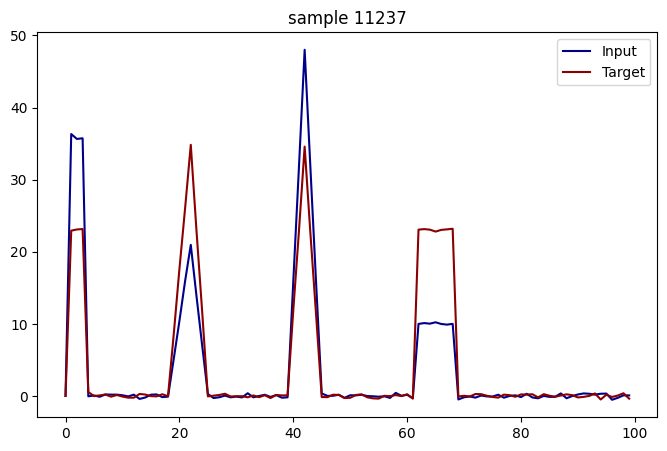

In [7]:
fig,ax=plt.subplots(figsize=(8,5))

draw(ax,X,Y,i=torch.randint(0,N,(1,))[0])


In [8]:

train_input = X
train_targets = Y

model_1 = model1()

print(sum([p.numel() for p in model_1.parameters() if p.requires_grad]))

nb_epochs = 50
batch_size = 100
n_batches = N//batch_size

optimizer = torch.optim.Adam(model_1.parameters(), lr = 1e-3)
mse_loss = nn.MSELoss()
mu, std = train_input.mean(), train_input.std()
L1 = []

for e in tqdm(range(10)):
    running_loss = 0.
    
    for ibatch,(_input, targets) in enumerate(zip(train_input.split(batch_size), train_targets.split(batch_size))):
        output = model_1((_input - mu) / std)
        loss = mse_loss(output, targets)
        running_loss += loss.data.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    L1.append(running_loss/(ibatch+1))


62337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:41<00:00, 10.12s/it]


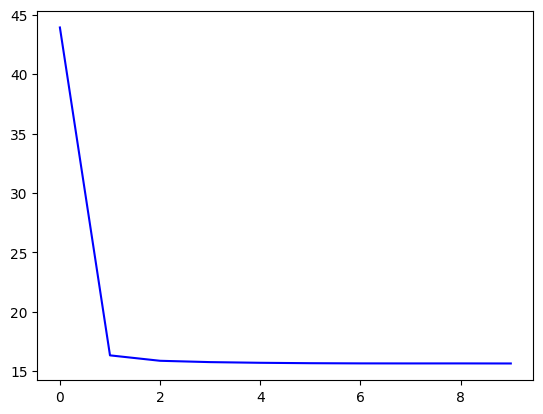

In [9]:
fig, ax = plt.subplots()
ax.plot(L1,label="Without attention",color="blue")
#ax.set_xscale("log")

In [10]:
model_2 = model2()

print(sum([p.numel() for p in model_2.parameters() if p.requires_grad]))

optimizer = torch.optim.Adam(model_2.parameters(), lr = 7e-4)
mse_loss = nn.MSELoss()
mu, std = train_input.mean(), train_input.std()
L2 = []

for e in tqdm(range(nb_epochs)):
    running_loss = 0.
    for ibatch,(_input, targets) in enumerate(zip(train_input.split(batch_size), train_targets.split(batch_size))):
        output = model_2((_input - mu) / std)
        loss = mse_loss(output, targets)
        running_loss += loss.data.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    L2.append(running_loss/(ibatch+1))


54081


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [08:42<00:00, 10.46s/it]


In [11]:
fig, ax = plt.subplots()
ax.plot(L1,label="Without attention",color="blue")
ax.plot(L2,label="With attention",color="orange")
ax.plot([0,len(L2)],[0,0],color="black",ls=":")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Training MSE")
ax.set_xlabel("# epochs")
ax.legend()

Text(0.5, 1.0, 'weights: A')

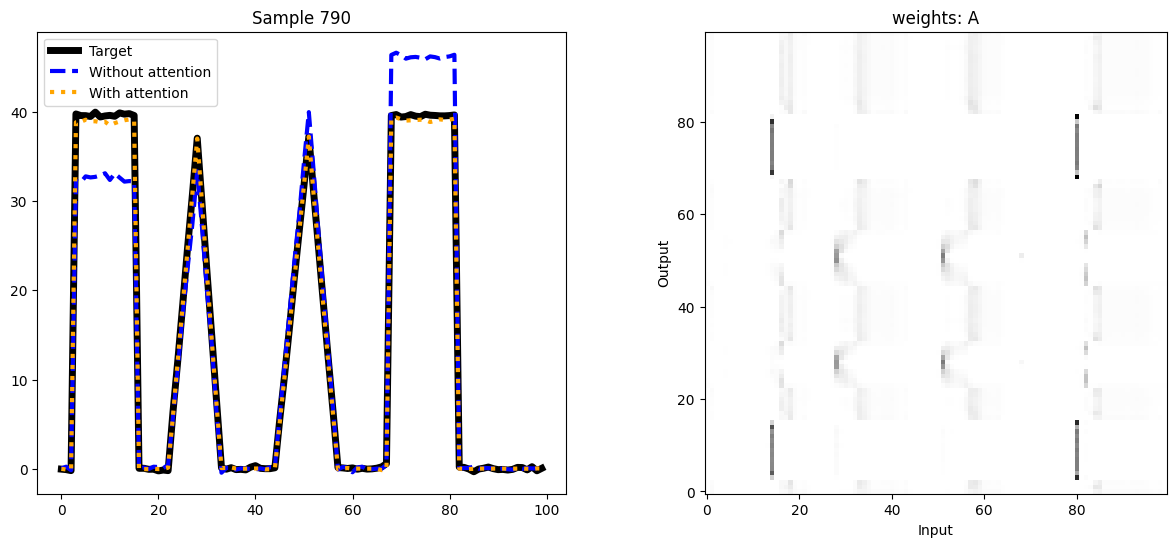

In [12]:
nsmall=1000
with torch.no_grad():
    yhat_1 = model_1((train_input[:nsmall]-mu)/std)
    yhat_2,A = model_2((train_input[:nsmall]-mu)/std,explain=True)

i = torch.randint(0,yhat_1.shape[0],(1,))[0]
fig, axes = plt.subplots(1,2,figsize=(15,6))
ax = axes[0]
ax.plot(train_targets[i,0,:],label="Target", color="black",lw=5)
ax.plot(yhat_1[i,0,:],label="Without attention", color="blue",lw=3, ls="--")
ax.plot(yhat_2[i,0,:],label="With attention", color="orange",lw=3, ls=":")
ax.set_title("Sample {}".format(i))
ax.legend()

ax = axes[1]
ax.imshow(A[i], origin="lower",cmap="binary")
ax.set_xlabel("Input")
ax.set_ylabel("Output")
ax.set_title("weights: A")